In [1]:
import os
import sys
# from parent directory imports
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import copy
import pickle
import numpy as np
from tqdm import tqdm
from itertools import product
from typing import List

from sklearn import datasets

import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import ticker
import seaborn as sns
sns.set()

import torch
import torch.nn as nn
import torch.distributions as dist
import torch.optim as optim
from torch.optim.optimizer import Optimizer

import hamiltorch

from source.utils.seeding import fix_seeds
from source.networks.batched_modules import LinearND

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
os.makedirs("results_introexample", exist_ok=True)

In [3]:
global_seed = 42

## Gaussian Dataset

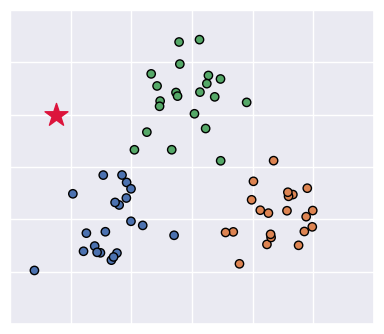

In [4]:
n_samples = 21

location = 4
std = 1.5

rng = np.random.default_rng(seed=global_seed)

x_train_1 = rng.normal((-location, -location / 2), (std, std), (n_samples, 2))
y_train_1 = np.zeros_like(x_train_1[..., 0])
x_train_2 = rng.normal((location, -location / 2), (std, std), (n_samples, 2))
y_train_2 = np.ones_like(x_train_2[..., 0])
x_train_3 = rng.normal((0, (location / 2) * np.sqrt(2)), (std, std), (n_samples, 2))
y_train_3 = np.ones_like(x_train_2[..., 0]) * 2

x_train = np.concatenate((x_train_1, x_train_2, x_train_3))
y_train = np.concatenate((y_train_1, y_train_2, y_train_3)).astype(np.int32)

x_new = np.asarray([-6, 2]).reshape(1, -1)

n_classes = 3

x_labels= ["dim 1", "dim 2"]

num_mesh = 100
x_test = np.asarray(np.meshgrid(np.linspace(-8, 8, num_mesh),
                                np.linspace(-6, 6, num_mesh)))
x_test = np.moveaxis(x_test, 0, -1)
x_test = x_test.reshape(-1, 2)

plt.figure(figsize=(4, 3.5))
plt.scatter(x_train[:, 0], x_train[:, 1], c=[f"C{y}" for y in y_train], edgecolors="black")
plt.scatter(x_new[:, 0], x_new[:, 1], marker="*", c="crimson", s=300, edgecolors="crimson", linewidths=1, zorder=99)
#plt.xlabel(x_labels[0])
#plt.ylabel(x_labels[1])
#plt.xticks([])
#plt.yticks([])
plt.xticks(ticks=np.linspace(-8, 8, 7), labels=[])
plt.yticks(ticks=np.linspace(-6, 6, 7), labels=[])
plt.xlim(np.min(x_test[:, 0]), np.max(x_test[:, 0]))
plt.ylim(np.min(x_test[:, 1]), np.max(x_test[:, 1]))
plt.tight_layout()
plt.savefig(os.path.join("results_introexample", "dataset.pdf"))
plt.show()

In [5]:
# Make tensors from dataset

x_train_t = torch.as_tensor(x_train).to(device=device, dtype=torch.float32)
y_train_t = torch.as_tensor(y_train).to(device=device, dtype=torch.long)
x_test_t = torch.as_tensor(x_test).to(device=device, dtype=torch.float32)
x_new_t = torch.as_tensor(x_new).to(device=device, dtype=torch.float32)

### Helper Functions

In [6]:
def laplace_smoothing(x, eps=1e-3):
    x = x + eps
    return x / torch.sum(x, dim=-1, keepdim=True)

def fit(network, opt, X, y, iterations, x_new=None, y_new=None, plot=True, verbose=True):
    losses, new_losses = list(), list()
    ce = nn.CrossEntropyLoss()
    mse = nn.MSELoss()
    
    y = nn.functional.one_hot(y)

    for _ in tqdm(range(iterations), disable = not verbose):

        pred = network.forward(X)
        loss = ce(pred, laplace_smoothing(y))

        losses.append(loss.item())

        if x_new is not None and y_new is not None:
            new_loss = ce(network.forward(x_new), laplace_smoothing(y_new))
            #new_loss = mse(torch.flatten(network.forward(x_new)), torch.flatten(laplace_smoothing(y_new)))
            loss += new_loss

            new_losses.append(new_loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()

    if plot:
        plt.plot(losses, label="train loss")
        if len(new_losses) > 0:
            plt.plot(new_losses, label="new loss")
        plt.yscale("log")
        plt.legend()
        plt.show()

    return network, losses[-1]

def fitND(network, opt, X, y, iterations, x_new=None, y_new=None, verbose=True):
    losses = list()
    ce = nn.CrossEntropyLoss(reduction="none")
    
    X = X.unsqueeze(1).expand(-1, n, -1)
    y = nn.functional.one_hot(y).unsqueeze(1).expand(-1, n, -1)

    if x_new is not None and y_new is not None:
        x_new = x_new.unsqueeze(1).expand(-1, n, -1)
        y_new = y_new.unsqueeze(1).expand(-1, n, -1)

    for _ in tqdm(range(iterations), disable = not verbose):

        pred = network.forward(X)

        loss = ce(torch.permute(pred, (0, 2, 1)), torch.permute(laplace_smoothing(y), (0, 2, 1)))
        loss = torch.mean(loss, dim=0)

        losses.append(loss.detach().cpu().numpy())

        loss = torch.sum(loss)

        if x_new is not None and y_new is not None:

            pred = network.forward(x_new)
            
            new_loss = torch.sum(torch.mean(ce(torch.permute(pred, (0, 2, 1)), torch.permute(laplace_smoothing(y_new), (0, 2, 1))), dim=0))
            loss += new_loss

        opt.zero_grad()
        loss.backward()
        opt.step()

    return network, losses[-1]

def get_network(n, in_size, hidden_size, out_size):
    layers = [list(), list(), list()]
    # do it this strange way, to preserve initialization for remaining nets when changing 'n'
    for _ in range(n):
        layers[0].append(nn.Linear(in_size, hidden_size))
        layers[1].append(nn.Linear(hidden_size, hidden_size))
        layers[2].append(nn.Linear(hidden_size, out_size))
    
    return nn.Sequential(LinearND(layers[0]),
                         nn.ReLU(),
                         LinearND(layers[1]),
                         nn.ReLU(),
                         LinearND(layers[2]))


class LinearND(nn.Module):
    def __init__(self, layers:List[nn.Linear]) -> None:
        super(LinearND, self).__init__()

        device = layers[0].weight.device

        self.weight = nn.Parameter(torch.stack([layer.weight.data.cpu().clone() for layer in layers], dim=0).to(device))
        self.bias = nn.Parameter(torch.stack([layer.bias.data.cpu().clone() for layer in layers], dim=0).to(device))

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return torch.matmul(input.unsqueeze(-2), self.weight.mT).squeeze(-2).add(self.bias)

## General Parameters

In [7]:
lr = 1e-2
hidden_size = 10
weight_decay = 1e-2
iterations = 500

# how many concurrent networks?
n = 20

In [8]:
fix_seeds(global_seed)

pred_test = list()

y_new_t = torch.ones((1, n_classes)).to(device=device, dtype=torch.float32)

y_new_t[:, 0] = 0.1
y_new_t[:, 1] = 0.8
y_new_t[:, 2] = 0.1

In [9]:
network = get_network(n, len(x_labels), hidden_size, n_classes)
print("# parameters:", sum(p.numel() for p in network.parameters()))
network.to(device)
network.train()

opt = optim.Adam(params=network.parameters(), lr=lr, weight_decay=weight_decay)

# parameters: 3460


In [10]:
#network, _ = fitND(network, opt, x_train_t, y_train_t, iterations, x_new_t, y_new_t)
network, _ = fitND(network, opt, x_train_t, y_train_t, iterations)

x_test_t_ = x_test_t.unsqueeze(1).expand(-1, n, -1)
preds_ = torch.softmax(network.forward(x_test_t_), dim=2).detach().cpu().numpy()

print(preds_.shape)

preds = np.mean(preds_, axis=1)

100%|██████████| 500/500 [00:02<00:00, 169.59it/s]

(10000, 20, 3)


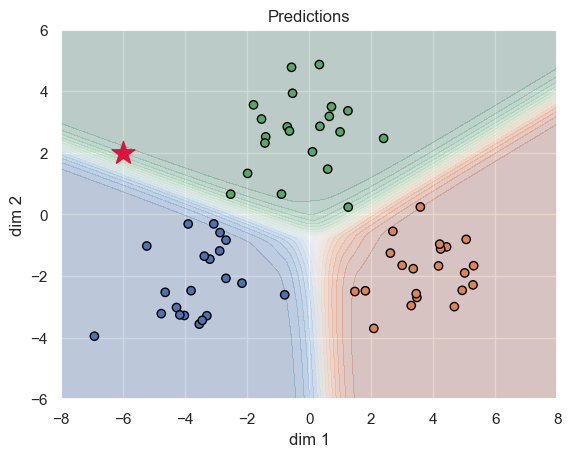

In [11]:
plt.title("Predictions")
plt.contourf(x_test[:, 0].reshape(num_mesh, num_mesh), x_test[:, 1].reshape(num_mesh, num_mesh),
             preds[:, 0].reshape(num_mesh, num_mesh), cmap="Blues", alpha=0.2, levels=np.linspace(0.33, 1, 11))
plt.contourf(x_test[:, 0].reshape(num_mesh, num_mesh), x_test[:, 1].reshape(num_mesh, num_mesh),
             preds[:, 1].reshape(num_mesh, num_mesh), cmap="Oranges", alpha=0.2, levels=np.linspace(0.33, 1, 11))
plt.contourf(x_test[:, 0].reshape(num_mesh, num_mesh), x_test[:, 1].reshape(num_mesh, num_mesh),
             preds[:, 2].reshape(num_mesh, num_mesh), cmap="Greens", alpha=0.2, levels=np.linspace(0.33, 1, 11))
plt.scatter(x_train[:, 0], x_train[:, 1], c=[f"C{y}" for y in y_train], edgecolors="black")
plt.scatter(x_new[:, 0], x_new[:, 1], marker="*", c="crimson", s=300, edgecolors="crimson", linewidths=1, zorder=99)
plt.xlabel(x_labels[0])
plt.ylabel(x_labels[1])
#plt.savefig(os.path.join("results_introexample", "class_prediction_simple.pdf"))
plt.show()

# Simplex

In [21]:
# parameters
subdiv = 5

In [22]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=subdiv)

def xy2bc(xy, pairs, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    AREA = 0.5 * 1 * 0.75**0.5
    tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

def bc2xy(bc):
    '''Converts barycentric coordinates to 2D Cartesian coordinates.'''
    vertices = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3) / 2]])
    x1, y1 = vertices[0]
    x2, y2 = vertices[1]
    x3, y3 = vertices[2]
    u, v, w = bc
    x = (x1 - x3) * u + (x2 - x3) * v + x3
    y = (y1 - y3) * u + (y2 - y3) * v + y3
    return np.array([x, y])

In [23]:
targets = list()
for xy in zip(trimesh.x, trimesh.y):
    targets.append(np.asarray(xy2bc(xy, pairs)))
targets = np.stack(targets, axis=0)

ce = nn.CrossEntropyLoss()

nlls_ = list()

for target in tqdm(targets):

    fix_seeds(global_seed)

    y_new_t = torch.as_tensor(target.reshape(1, -1)).to(device=device, dtype=torch.float32)

    network = get_network(n, len(x_labels), hidden_size, n_classes)
    network.to(device)
    network.train()

    opt = optim.Adam(params=network.parameters(), lr=lr, weight_decay=weight_decay)

    _, loss = fitND(network, opt, x_train_t, y_train_t, iterations, x_new_t, y_new_t, verbose=False)

    nlls_.append(loss)

100%|██████████| 561/561 [20:02<00:00,  2.14s/it]


In [24]:
nlls = [np.median(l) for l in nlls_]
lls = [np.median(np.exp(l)) for l in nlls_]

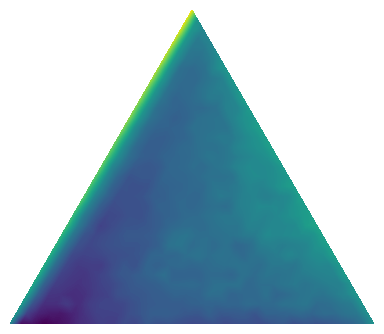

In [25]:
plt.figure(figsize=(4, 3.5))
tcf = plt.tricontourf(trimesh, nlls, levels=np.linspace(np.min(nlls), np.max(nlls), 151), cmap='viridis_r')
#plt.title("Original")
plt.axis('off')
plt.axis('equal')
plt.tight_layout()
plt.savefig(os.path.join("results_introexample", "simplex.png"))
plt.show()

## Deep Ensembles

In [26]:
# parameters
n_ensemble = 50

In [27]:
fix_seeds(global_seed)

pred_test = list()

for e in tqdm(range(n_ensemble)):
    network = nn.Sequential(nn.Linear(len(x_labels), hidden_size),
                            nn.ReLU(),
                            nn.Linear(hidden_size, hidden_size),
                            nn.ReLU(),
                            nn.Linear(hidden_size, n_classes))
    network.to(device)
    network.train()

    opt = optim.Adam(params=network.parameters(), lr=lr, weight_decay=weight_decay)

    losses = list()

    fit(network, opt, x_train_t, y_train_t, iterations, plot=False, verbose=False)

    with torch.no_grad():
        network.eval()
        preds = torch.softmax(network.forward(x_new_t), dim=1).cpu().numpy()
    pred_test.append(preds)

pred_test = np.asarray(pred_test)

100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


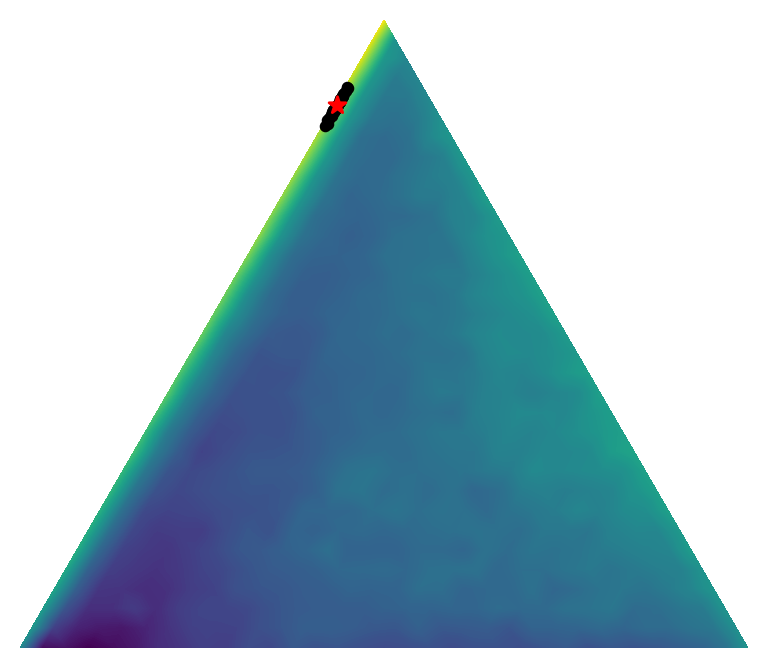

In [28]:
plt.figure(figsize=(4, 3.5), dpi=200)
plt.tricontourf(trimesh, nlls, levels=np.linspace(np.min(nlls), np.max(nlls), 151), cmap='viridis_r')
for point in pred_test[:, 0, :]:
    plt.scatter(bc2xy(point)[0], bc2xy(point)[1], c="black", s=10)
plt.scatter(bc2xy(np.mean(pred_test[:, 0, :], axis=0))[0], bc2xy(np.mean(pred_test[:, 0, :], axis=0))[1], marker="*", c="red", s=40)
#plt.title("Deep Ensembles")
plt.axis('off')
plt.axis('equal')
plt.tight_layout()
plt.savefig(os.path.join("results_introexample", "ensembles.png"))
plt.show()

# MC-Dropout

In [29]:
# parameters
dropout_rate = 0.1
n_samples = 1_000

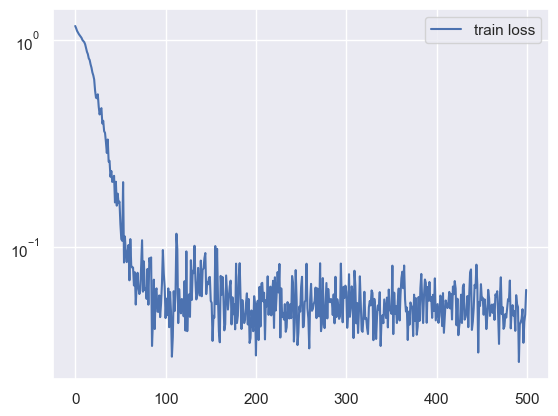

In [30]:
fix_seeds(global_seed)
pred_test = list()

network = nn.Sequential(nn.Linear(len(x_labels), hidden_size),
                        nn.Dropout(p=dropout_rate),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.Dropout(p=dropout_rate),
                        nn.ReLU(),
                        nn.Linear(hidden_size, n_classes))
network.to(device)
network.train()

opt = optim.Adam(params=network.parameters(), lr=lr, weight_decay=weight_decay)

losses = list()

fit(network, opt, x_train_t, y_train_t, iterations, plot=True, verbose=False)

with torch.no_grad():
    network.train()
    for _ in range(n_samples):
        pred_test.append(torch.softmax(network.forward(x_new_t), dim=1).cpu().numpy())

pred_test = np.asarray(pred_test)


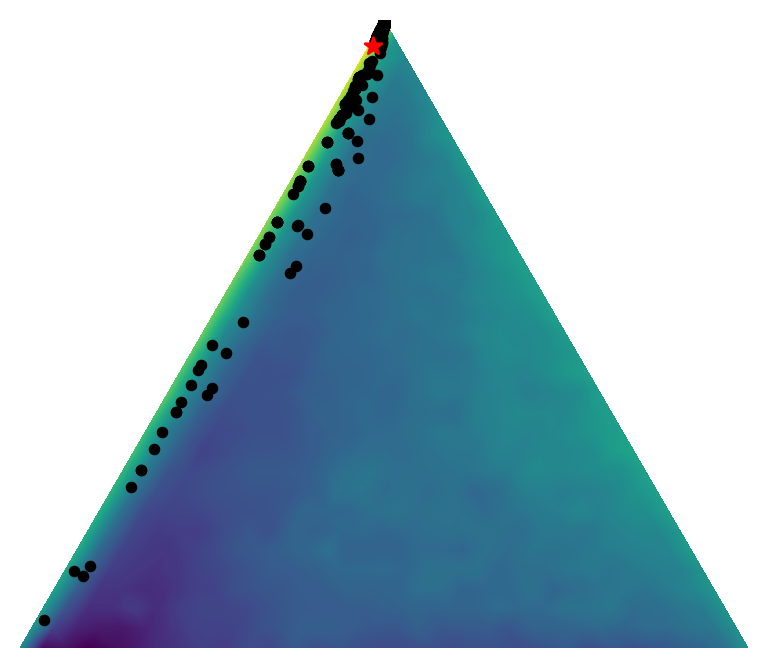

In [31]:
from matplotlib import ticker
plt.figure(figsize=(4, 3.5), dpi=200)
plt.tricontourf(trimesh, nlls, levels=np.linspace(np.min(nlls), np.max(nlls), 151) , cmap='viridis_r')
for point in pred_test[:, 0, :]:
    plt.scatter(bc2xy(point)[0], bc2xy(point)[1], c="black", s=10)
plt.scatter(bc2xy(np.mean(pred_test[:, 0, :], axis=0))[0], bc2xy(np.mean(pred_test[:, 0, :], axis=0))[1], marker="*", c="red", s=40)
#plt.title("MC-Dropout")
plt.axis('off')
plt.axis('equal')
plt.tight_layout()
plt.savefig(os.path.join("results_introexample", "mc_dropout.png"))
plt.show()

# HMC

In [32]:
# parameters
step_size = 0.001 #0.0006
num_samples = 500
burn = 100
L = 500
mass = 1e-0

In [33]:
fix_seeds(global_seed)
hamiltorch.set_random_seed(global_seed)

network = nn.Sequential(nn.Linear(len(x_labels), hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, n_classes))
network.to(device)
network.train()

params_init = hamiltorch.util.flatten(network).to(device).clone()
print('Parameter size: ',params_init.shape[0])

Parameter size:  173


In [34]:
inv_mass = torch.ones(params_init.shape, device=device) / mass
integrator = hamiltorch.Integrator.EXPLICIT
sampler = hamiltorch.Sampler.HMC

params_hmc = hamiltorch.sample_model(network, x_train_t, y_train_t, model_loss='multi_class_linear_output', integrator=integrator, sampler=sampler, 
                                     params_init=params_init, num_samples=num_samples, burn=burn, step_size=step_size, num_steps_per_sample=L)

y_test_t = torch.ones((len(x_test), 1)).to(device=device, dtype=torch.float32)
pred_list, log_prob_list = hamiltorch.predict_model(network, x=x_test_t, y=y_test_t, model_loss='multi_class_linear_output', samples=params_hmc[:])

Sampling (Sampler.HMC; Integrator.EXPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:23:12 | 0d:00:00:00 | #################### | 500/500 | 0.36       
Acceptance Rate 1.00


In [35]:
preds = torch.softmax(pred_list, dim=2)
preds = preds.cpu().numpy()

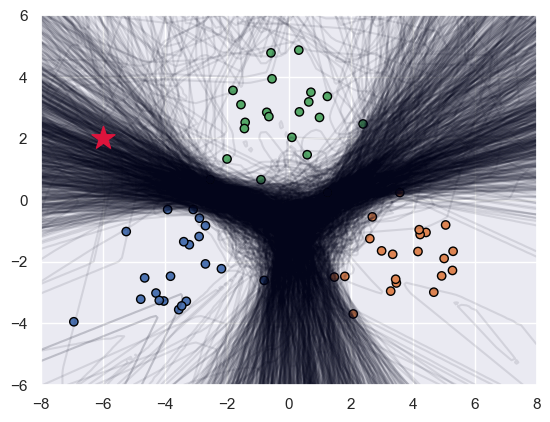

In [36]:
for pred in preds[:-1]:
    plt.contour(x_test[:, 0].reshape(num_mesh, num_mesh), x_test[:, 1].reshape(num_mesh, num_mesh),
                pred[:, 0].reshape(num_mesh, num_mesh), alpha=0.1, levels=[0.33])
    plt.contour(x_test[:, 0].reshape(num_mesh, num_mesh), x_test[:, 1].reshape(num_mesh, num_mesh),
                pred[:, 1].reshape(num_mesh, num_mesh), alpha=0.1, levels=[0.33])
    plt.contour(x_test[:, 0].reshape(num_mesh, num_mesh), x_test[:, 1].reshape(num_mesh, num_mesh),
                pred[:, 2].reshape(num_mesh, num_mesh), alpha=0.1, levels=[0.33])
plt.scatter(x_train[:, 0], x_train[:, 1], c=[f"C{y}" for y in y_train], edgecolors="black")
plt.scatter(x_new[:, 0], x_new[:, 1], marker="*", c="crimson", s=300, edgecolors="crimson", linewidths=1, zorder=99)
plt.show()

In [37]:
pred_list, log_prob_list = hamiltorch.predict_model(network, x=x_new_t, y=y_train_t[[0]], model_loss='multi_class_linear_output', samples=params_hmc[:])
preds = torch.softmax(pred_list, dim=2)
preds = preds.cpu().numpy()
print(preds.shape)

(400, 1, 3)


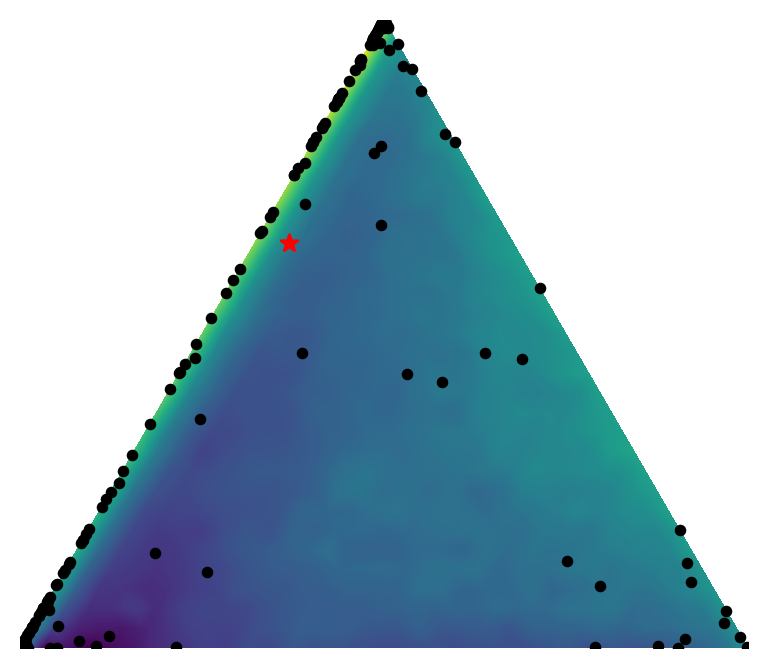

In [49]:
plt.figure(figsize=(4, 3.5), dpi=200)
plt.tricontourf(trimesh, nlls, levels=np.linspace(np.min(nlls), np.max(nlls), 151), cmap='viridis_r')
for point in preds[:, 0, :]:
    plt.scatter(bc2xy(point)[0], bc2xy(point)[1], c="black", s=10)
plt.scatter(bc2xy(np.mean(preds[:, 0, :], axis=0))[0], bc2xy(np.mean(preds[:, 0, :], axis=0))[1], marker="*", c="red", s=40)
#plt.title("HMC")
plt.axis('off')
plt.axis('equal')
plt.tight_layout()
plt.savefig(os.path.join("results_introexample", "hmc.png"))
plt.show()

# Adversarial Model Search

In [51]:
# parameters
adversaries = 1
optim_steps = 70
adv_iterations = 10
lr_adv = 1e-3

c_0 = 1e+0
eta = 4

In [52]:
fix_seeds(global_seed)

network = nn.Sequential(nn.Linear(len(x_labels), hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, n_classes))
network.to(device)
network.train()
ce = nn.CrossEntropyLoss()

opt = optim.Adam(params=network.parameters(), lr=lr, weight_decay=weight_decay)

fit(network, opt, x_train_t, y_train_t, iterations, plot=False, verbose=False)

# predictions with original network
with torch.no_grad():
    test_net_pred = torch.softmax(network.forward(x_test_t), dim=1).cpu().numpy().reshape(1, -1, n_classes)
    train_net_pred = network.forward(x_train_t)
    train_net_ce = ce(train_net_pred, y_train_t)

all_log_likelihoods = list()
pred_test = list()
g_cpu = torch.Generator(device="cpu")

# Adversarial Attack
for a, l in tqdm(product(range(adversaries), range(n_classes))):
    preds = list()
    
    y_test_t = torch.LongTensor([l]).to(device=device)


    adversarial_network = copy.deepcopy(network)
    adversarial_network.train()

    opt = optim.Adam(params=adversarial_network.parameters(), lr=lr_adv, weight_decay=weight_decay)
    log_likelihoods, best_iter = list(), 0
    min_objective_loss = 1e9

    c = c_0
    for ad_i in range(adv_iterations):
        for op_s in range(optim_steps):
            train_adv_pred = adversarial_network.forward(x_train_t)
            penalty = ce(train_adv_pred, y_train_t)
            
            test_adv_pred = adversarial_network.forward(x_new_t.reshape(1, -1))
            objective = ce(test_adv_pred, y_test_t)

            loss = objective + c * penalty

            log_likelihoods.append(-penalty.item())
            
            with torch.no_grad():
                adversarial_network.eval()
                preds.append(torch.softmax(adversarial_network.forward(x_new_t.reshape(1, -1)), dim=1).cpu().numpy())
                adversarial_network.train()

            opt.zero_grad()
            loss.backward()
            opt.step()
        
        # update parameter
        c *= eta
        
    all_log_likelihoods.append(log_likelihoods)

    pred_test.append(preds)

3it [00:07,  2.38s/it]


In [53]:
preds = np.asarray(pred_test).reshape(-1, 1, n_classes)
lls = np.asarray(all_log_likelihoods).reshape(-1, )
print(len(lls) // 2)
indexes = np.argsort(lls)[-(len(lls) // 2):]
#preds = preds[indexes]
print(lls.shape, preds.shape)

1050
(2100,) (2100, 1, 3)


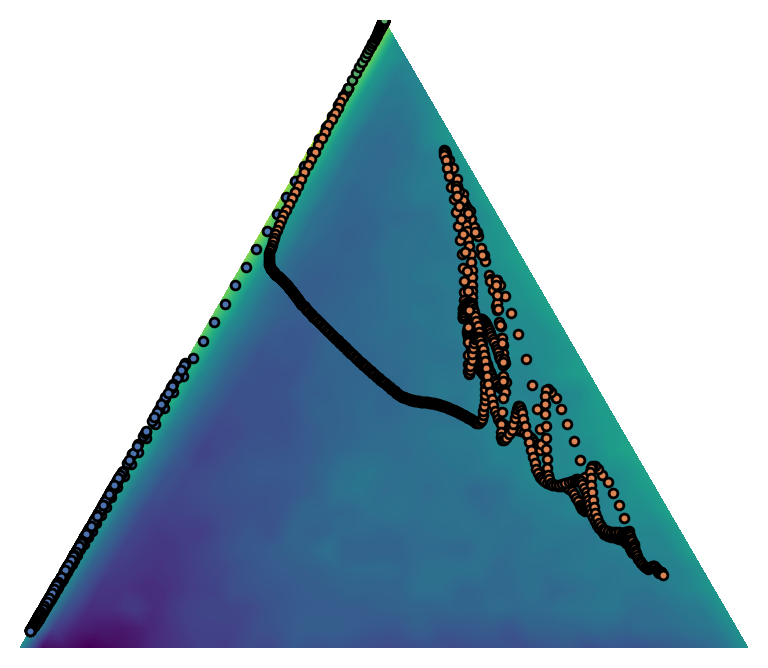

In [58]:
separator = (optim_steps * adv_iterations)

plt.figure(figsize=(4, 3.5), dpi=200)
plt.tricontourf(trimesh, nlls, levels=np.linspace(np.min(nlls), np.max(nlls), 151), cmap='viridis_r')
for point in preds[:separator, 0, :]:
    plt.scatter(bc2xy(point)[0], bc2xy(point)[1], c="C0", s=10, edgecolors="black")
for point in preds[separator:2*separator, 0, :]:
    plt.scatter(bc2xy(point)[0], bc2xy(point)[1], c="C1", s=10, edgecolors="black")
for point in preds[2*separator:, 0, :]:
    plt.scatter(bc2xy(point)[0], bc2xy(point)[1], c="C2", s=10, edgecolors="black")
#plt.scatter(bc2xy(np.mean(preds[:, 0, :], axis=0))[0], bc2xy(np.mean(preds[:, 0, :], axis=0))[1], marker="*", c="red", s=40)
#plt.title("Adversarial Models")
plt.axis('off')
plt.axis('equal')
plt.tight_layout()
plt.savefig(os.path.join("results_introexample", "ams.png"))
plt.show()